In [1217]:
#imported libraries
#%matplotlib inline
#start = time.time() 
import webbrowser
import numpy as np
import time
import astropy as ap
import matplotlib.pyplot as plt
import photutils
from astropy.stats import sigma_clipped_stats, SigmaClip, gaussian_fwhm_to_sigma,mad_std
from photutils import centroid_com , centroid_1dg, centroid_2dg,find_peaks, StdBackgroundRMS,fit_2dgaussian 
from photutils import CircularAperture, CircularAnnulus,aperture_photometry, MedianBackground, IntegratedGaussianPRF, DAOStarFinder
from photutils import source_properties,detect_sources,detect_threshold
from astropy.io import fits
import scipy.optimize as opt
import os
from natsort import natsorted
import fnmatch
from astropy.visualization import simple_norm,SqrtStretch
from astropy.convolution import Gaussian2DKernel
from astropy.visualization.mpl_normalize import ImageNormalize
import glob
import astropy.units as u
from astropy.time import Time
from astropy.utils import iers
iers.Conf.iers_auto_url.set('ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all')
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude, EarthLocation, AltAz  # High-level coordinates
import re
from astropy.modeling.models import Ellipse2D
import matplotlib.patches as mpatches
import pandas as pd
import pickle
import papermill as pm
from copy import copy
import dateutil.parser as dp
import warnings
from photutils.utils import NoDetectionsWarning
import math
#stores the parent directory for the sake of reset
parent=r'C:\Users\roryf\Downloads\A Honours project\Comp'

'D:\\Sharpcap\\2020-02-10\\Capture\\34g-9ms\\34g-9ms-2'

# Functions:

In [2]:
#diaThe folder crawler
def Foldercrawl(runfunc,levels,fold):
    #levels of folder 'walking' (1 or 2)
    #2 means that 2 levels of sub folders are investigated
    if runfunc==1:
        totalfolders=[]
        #folder input for either the parent or grandparent dir
        os.chdir(fold)
        sub1=next(os.walk('.'))[1]
        if levels==2:
            for w in sub1:
                q=os.path.join(fold,w)
                os.chdir(q)
                j=next(os.walk('.'))[1]
                for h in j:
                    totalfolders.append(os.path.join(q,h))
            darklist=[s for s in totalfolders if 'dark' in s]
            workfolders=list(set(totalfolders) - set(darklist))    
            print(len(workfolders))
        if levels==1:
            for w in sub1:
                totalfolders.append(os.path.join(fold,w))
            #displays the list of found folders
            darklist=[s for s in totalfolders if 'dark' in s]
            workfolders=list(set(totalfolders) - set(darklist))
            print(len(workfolders))        
    else:
        print('Function skipped')
        workfolders=[]
    return(workfolders)

In [3]:
#Processing function, limited to light/dark but can be easily expanded to Flat, DFlats.Creates and outputs to \Calibrated
def LDProcessor(runfunc,workfolders,nsig):
    if runfunc==1:
        #Ensure the capture location has folders named 'light', 'dark' and a concap FITS file called 'conte'
        #This assignment references the processing notebook for the dark subtraction and stacking of the captures
        #The notebook is stored in the parent directory
        filename=parent+'\\'+"Imageprocwoutflats-prime.ipynb" 
        #This is the dir where a lights, darks and conte.FITS should exist for processing 
        for home in workfolders:
            print(home)
            #Input file, output file, parameters #home= the capture folder, start is the first file, end is the last
            #leaving out start and end variables will automatically assign as first and last files, full range possible
            pm.execute_notebook(filename,filename,
            #currently processes all                    
            parameters = dict(home=home,nsig=nsig))
    else:
        print('Function skipped')

In [4]:
#Capture Series Timing Func, shows the total capture time and the lag between captures
def Timingscript(runfunc):
    if runfunc==1:  
        timestamp=[]
        exptime=[]
        j=natsorted(fnmatch.filter(os.listdir(),'*cal*'))
        for t in j:
            fitsfile=t
            hdul= fits.open(fitsfile)
            data = hdul[0].data
            h1=hdul[0].header
            d1=hdul[0].data
            parsed_t = dp.parse(h1['DATE-OBS'])
            timestamp.append(parsed_t.timestamp())
        exptime.append(h1['EXPTIME'])    
        duration=timestamp[-1]-timestamp[0] 
        val=np.array(np.ones(len(timestamp)-1))
        for i in range (0,len(timestamp)-1):
            val[i-1]=timestamp[i+1]-timestamp[i]
        print('Of ' +str(len(j))+' captures:'),print('The median spacing between captures is ' + str(round(np.median(val),4))+'s')   
        print('This compares to the set exposure time of ' + str(exptime[0])+'s')
        print('For a total capture time of: '+ str(duration)+'s')
        nd=np.arange(0, len(val), 1)
        plt.rcParams["figure.figsize"] = [7,4]
        plt.scatter(nd,val)
        plt.title('Plot showing the lag between captures over the course of '+str(len(timestamp))+' captures')
    else:
        print('Function skipped')   
        duration=0
        timestamp=0
        exptime=0
    return(duration,timestamp,exptime)

In [5]:
#Server operator- Calls and recieves from Nova Astrometry.net
def PlatesolveNova(runfunc,targdir,calloc,apikey,duration,lonn,latt,height,prevconcap):
    if runfunc==1:
        airmass=[]
        concap=os.path.dirname(targdir)+str('\conte.FITS')
        #concap=targdir+str('\conte.FITS')
        thing=calloc+str('\match.FITS')
        os.chdir(calloc)
        hdul= fits.open(concap)
        date=(hdul[0].header['DATE-OBS'])  
        if date in prevconcap:
            RAval=prevconcap[date][0]    
            DECval=prevconcap[date][1]  
            airmass=prevconcap[date][2]
            daylength=((24*3600))
            arcang=(duration/daylength)*360
            angspeed=np.cos(np.deg2rad(DECval))*15
            print('no need to call to server')
        else:    
            print('server call needed')
            #Ensure that the file NovaAstAPI.py is present at that location
            #the apikey is specific to the nova.astrometry account and concap references the conte.FITS
            #The file, NovaAstAPI is the client api and needs to be downloaded and location referenced here!
            %run "C:\Users\roryf\Downloads\A Honours project\Comp\NovaAstAPI.py" --apikey=$apikey --upload=$concap --newfits=$thing --crpix-center
            #accesses the pixel info from the fits header
            hdul= fits.open('match.fits')
            h1=hdul[0].header
            date=(h1['DATE-OBS'])  
            RAval=(h1['CRVAL1']) 
            DECval=(h1['CRVAL2'])
            angspeed=np.cos(np.deg2rad(DECval))*15
            starcoord=SkyCoord(ra=RAval*u.degree, dec=DECval*u.degree, frame='icrs')
            locdat=EarthLocation(lat=latt*u.deg, lon=lonn*u.deg, height=height*u.m)
            UTCtime='20'+date[2:4]+'-'+date[5:7]+'-'+date[8:10]+' '+date[11:19]
            tim=Time(UTCtime)
            starcoordaltaz =starcoord.transform_to(AltAz(obstime=tim,location=locdat))
            #Azimuth from North
            print("Star's Altitude = {0.alt:.5}".format(starcoordaltaz))
            print("Star's Azimuth = {0.az:.5}".format(starcoordaltaz))
            nightaltaz = AltAz(obstime=tim,location=locdat)
            nightairmass = starcoord.transform_to(nightaltaz).secz
            print('The airmass is: ' + str(np.round(nightairmass,3)))
            airmass.append(str(np.round(nightairmass,3)))
            prevconcap[date]=([],[],[])
            prevconcap[date][0].append(RAval)
            prevconcap[date][1].append(DECval)
            prevconcap[date][2].append(airmass)
            #center pixels of the image
            print('The image center is located at RA= '+str(RAval)+' and DEC= ' +str(DECval))
            #Estimate of daylength
            daylength=((24*3600))
            arcang=(duration/daylength)*360
            angspeed=np.cos(np.deg2rad(DECval))*15
            print("The considered trails have an estimated angular path encompassing "+ str(arcang))
    else:
        date=[]
        print('Function skipped')
        RAval=[]
        DECval=[]
        arcang=[]
        angspeed=12 #assumed
        airmass=[]
        print('Assumed an angular speed of 12"/sec')
    return(date,RAval,DECval,arcang,angspeed,airmass,prevconcap)

In [6]:
#Star trail analysis Func,determines a list of stars based on the trails that pass the 2 sigma filter and length cut
def Starstack(runfunc,trailfile,duration,arcspeed,sigma,plotask):
    errorstat=0
    if runfunc==1:
        try:
            starcount=[]
            hdul= fits.open(trailfile)
            data = hdul[0].data
            NAXIS1,NAXIS2= data.shape[1],data.shape[0]
            #An estimate based on the duration in time, the assumed ''/s and a factor of .8 to reduce the estimate slightly.
            #15''/s comes from the angular speed stars appear to have when observing the celestial equator by 360deg/24 hours...15deg/h
            npixel=int(duration*arcspeed*1)
            threshold = detect_threshold(data, nsigma=sigma)
            with warnings.catch_warnings():
                    warnings.simplefilter('ignore', NoDetectionsWarning)
                    #the star traisl is are recovered if long enough and above background threshold
                    segm = detect_sources(data, threshold, npixels=npixel)
            cat=source_properties(data,segm)
            tbl = cat.to_table()
            #Filter parameters for an insufficient trail estimate
            tbl=tbl[tbl['min_value']>-1]
            tbl=tbl[tbl['eccentricity']>0.9]
            stars=np.array(np.ones((len(tbl),2)))
            #extracts the middle x/y positions for the star trail
            for p in range (0,len(stars)):
                head1, sep, tail = str(tbl[p][1]).partition(' ') 
                head2, sep, tail = str(tbl[p][2]).partition(' ') 
                stars[p]=(float(head1),float(head2))
            #store initial count
            starcount=len(stars)
            if plotask==1:
                norm = ImageNormalize(stretch=SqrtStretch())
                fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
                ax1.imshow(data, cmap='Greys_r', norm=norm)
                ax1.set_title('Data')
                cmap = segm.make_cmap(random_state=12345)
                ax1.imshow(segm, cmap=cmap, origin='lower')
                ax1.set_title('Stellar trail plots') 
        except (TypeError,ValueError): 
            print('Trail identification error-empty values defined')
            errorstat=1
            stars=[]
            starcount=[]
            tbl=[]
            segm=[]
    else:
        print('Function skipped')
    return(starcount,stars,NAXIS1,NAXIS2,tbl,data,segm,errorstat)

In [7]:
#Propmaster- A.K.A Star trail mask determination
def Maskmaker (runfunc,stars,data,tbl,segm,plotask):
    if runfunc==1:
        testma=[]
        aval=[]
        stackvals = dict()
        for s in range(0, len(stars)):
            stackvals[s]=([],[],[],[],[],[],[],[],[])
            #parameters are extracted from the trail table and used to tailor elliptical masks
        for i in range(0, len(stars)):    
            string2=(str(tbl['xcentroid'][i]),str(tbl['ycentroid'][i]),str(tbl['bbox_xmin'][i]),str(tbl['bbox_ymin'][i]),
            str(tbl['bbox_ymax'][i]),str(tbl['bbox_xmax'][i]),str(tbl['orientation'][i]),str(tbl['equivalent_radius'][i]))
            for d in range(0,len(string2)):
                temp= re.findall(r'[+-]?\d+(?:\.\d+)?',string2[d]) 
                temp= list(map(float, temp))[0]
                stackvals[i][d].append(temp)
        for s in range(0, len(stars)): 
            x0, y0 =stackvals[s][0][0], stackvals[s][1][0]
            a, b = (np.sqrt((stackvals[s][4][0]-stackvals[s][3][0])**2+(stackvals[s][5][0]-stackvals[s][2][0])**2)),(stackvals[s][7][0])*.8
            theta = Angle(stackvals[s][6][0], 'deg')
            e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,theta=theta.radian)
            y, x = np.mgrid[0:data.shape[0], 0:data.shape[1]]
            stackvals[s][8].append(e(x,y))
            testma.append(stackvals[s][8][0])
            testma[s][testma[s]<1]=1
            testma[s][testma[s]>1]=0
            testma[s]=np.array([x==1 for x in testma[s]])
            if plotask==1:
                fig, ax = plt.subplots(1, 1,figsize=(10, 10))
                ax.imshow(e(x, y), origin='lower', interpolation='none', cmap='Greys_r')
                e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='red', facecolor='none')
                ax.add_patch(e2)
                norm = ImageNormalize(stretch=SqrtStretch())
                plt.rcParams["figure.figsize"] = [12,30]
                plt.imshow(data, cmap='Greys_r', norm=norm)
                cmap = segm.make_cmap(random_state=12345)
                plt.imshow(segm, cmap=cmap, origin='lower')
            aval.append(a)
    else:
        print('Function skipped')
    return(testma,aval,stackvals)

In [8]:
#Star Bouncer- A.K.A Stellar filter
def Starfilter(runfunc,stars,testma,aval,stackvals):
    if runfunc==1:
        #First deletion criteria-proximate trails
        if starcount == len(stars):
            overlap=[]
            zipx=dict()
            zipy=dict()
            for k in range(0,len(testma)):
                zipx[k]=[]
                zipy[k]=[]    
                zipx[k],zipy[k]=np.where(testma[k]==False)
            for k in range(0,len(testma)):
                for l in range(0,len(testma)):
                    a=set(zip(zipx[k],zipy[k]))
                    b=set(zip(zipx[l],zipy[l]))
                    #If sets a,b have shared elements and are different then the stars will be removed
                    if ((len(set(a)&set(b))==0) == False) & ((set(a)==set(b))== False):
                        overlap.append(k)
            if overlap==[]:
                print('no overlaps')  
            else:
                stars=np.delete(stars,(overlap),0)
                testma=np.delete(testma,(overlap),0)
                aval=np.delete(aval,(overlap),0)
                print('proximate trails removed')    
            #second deletion criteria, too wide, probably not a normal undersaturated star
            widefail=[]
            #for current conditions 35 is an appropriate width for an undersaturated star, change later 
            for st in range(0,len(stars)):
                if stackvals[st][7][0]>35:
                    widefail.append(st)    
            stars=np.delete(stars,(widefail),0)
            testma=np.delete(testma,(widefail),0)   
            aval=np.delete(aval,(widefail),0)  
            print('width removal imposed')
            aval=np.array(aval)
            longest=np.sort(aval)[-1]
            wanted=aval[aval<longest*0.85]
            if wanted.size==0:
                print('no cut needed')
            else:
                aval=list(aval)
                #Third deletion criteria-incomplete trail
                cut=[]
                for i in range(0,len(wanted)):
                    cut.append(aval.index(wanted[i]))
                stars=np.delete(stars,(cut),0)
                testma=np.delete(testma,(cut),0)   
                aval=np.delete(aval,(cut),0)
                print('incomplete trails removed')
            print(stars)
        else: 
            print('Already removed invalid trails')
    else:
        print('Function skipped')
    return(stars,testma,aval)

In [988]:
#The Meditator - A.K.A Centre finder
def Centroider(runfunc,first,last,stars,bound,nsig,npix,testma,c0,c1):
    if runfunc==1:
        start = time.time()
        timekeep=dict()
        starx=dict()
        stary=dict()
        timevalcent=dict()
        for st in range(0,len(stars)):
            starx[st]=([],[]) 
            stary[st]=([],[])
            timekeep[st]=([]) 
            timevalcent[st]=([]) 
        #A loop is established that can run through all captures assuming they are sequentially named from  
        #for t in range(1,len(glob.glob('calibrated*fits'))+1):
        for t in range(first,last):  
            if t%150==0:
                print(str(t)+' !Wow BoB woW! '+str(t))
            data = fits.getdata('calibrated'+ str(t).zfill(1)+'.fits')
            if t==first:
                threshold3 = detect_threshold(data, nsigma=nsig)
                thresh=np.ones((NAXIS2,NAXIS1))*threshold3[0][0]
            for st in range(0,len(stars)):
                try:
                    #use a moving npixel in order to cover other ranges for other settings until you decide on one
                    #try:
                    #assuming an profile spread of 3 then 3x3 should be the minimum
                    with warnings.catch_warnings():
                        #Any warning is fine as if this isnt passable then it fails
                        warnings.simplefilter('ignore', NoDetectionsWarning)
                        segm = detect_sources(data, thresh, npixels=npix,mask=testma[st])    
                    cat=source_properties(data,segm)
                    tbl = cat.to_table()
                    head1, sep, tail = str(tbl[0][1]).partition(' ') 
                    head2, sep, tail = str(tbl[0][2]).partition(' ') 
                    if c0==1:
                        starx[st][0].append((float(head1)))
                        stary[st][0].append((float(head2)))
                    lf=round(float(head1)-bound)
                    ri=round(float(head1)+bound)
                    dw=round(float(head2)-bound)
                    upup=round(float(head2)+bound)
                    data4=data[dw:upup,lf:ri]
                    with warnings.catch_warnings():
                        #Other warning specs have issues
                        warnings.simplefilter('ignore', )
                        if c1==1:  
                            cent3=centroid_com(data4)
                            starx[st][1].append((cent3[0]+lf))
                            stary[st][1].append((cent3[1]+dw))
                    timekeep[st].append(t-1)
            #          #The data set is then reduced to the bounded region surrounding the peak pixel/star in order to reduce the magnitude of 
            #          #pixels to process for centroiding/also this bounded region may have to be tailored to the star profile as it will alter the value of the centroid. 
            #          #especially with elliptical captures this will need some consideration including a possible gaussian radial profile fit for the 
            #          #centroided region
                except (TypeError,ValueError):
                    #print('An Error occured')
                    continue
        end = time.time()
        time_taken = end - start
        print('Time: ',time_taken)
        for j in range(0,len(timekeep)):
             for i in range(0,len(timekeep[j])):
                timevalcent[j].append(timestamp[timekeep[j][i]])
        prerun=len(starx)        
        for f in range(0,prerun):        
            #works because option 0 is the initial detection
            print(len(timekeep[f]),len(starx[f][1]),t)                
            if len(timekeep[f])<(t*0.7):  
                #print(f)
                starx.pop(f)
                stary.pop(f)
                timevalcent.pop(f)
        total=t
        print(len(starx))
    else:
        print('Function skipped')
    return(starx,stary,timevalcent,nsig,t,timekeep)

In [10]:
#The Capenter - A.K.A Table maker
#Startographer- A.K.A determination of trail angle
def Tablemake(filename,timevalcent,airmass,lonn,latt,bound,imscale,NAXIS2,NAXIS1,RAval,DECval,duration):
    direction=((np.median(stary[list(stary.keys())[0]][0][-30:-1]))-(np.median(stary[list(stary.keys())[0]][0][0:30]))),((np.median(starx[list(starx.keys())[0]][0][-30:-1]))-(np.median(starx[list(starx.keys())[0]][0][0:30])))
    angle=np.rad2deg(math.atan2(direction[0],(direction[1])))
    #print(angle)
    if np.sign(angle)==-1:
        angle=angle+(2*180)
    print(angle)
    gain=[]
    offset=[]
    date=[]
    exptime=[]
    #accesses the pixel info from the fits header
    hdul= fits.open(filename)
    h1=hdul[0].header
    date=(h1['DATE-OBS']) 
    gain.append(h1['GAIN'])
    offset.append(h1['BLKLEVEL'])
    exptime.append(h1['EXPTIME']) 
    d = {'Date captured (UTC)': date,'Star number': len(timevalcent), 'Est Airmass': airmass[0],'Longitude': lonn,'Latitude': latt,
    'Gain': gain,'Exposure time': exptime,'Offset': offset,'bound':bound, 'pixscale': imscale,'Npixx':NAXIS2,'Npixy':NAXIS1
    ,'Centre RA': RAval,'Centre DEC': DECval,'Angle':angle,'Duration':duration}
    df1 = pd.DataFrame(data=d)
    df1.to_csv('context.CSV')
    return()

In [1617]:
#The large scale Seeing estimator
def Estimator (timcents,imscale,D,lambd,sdval,disp):
    conv=206264.806
    medd=[]
    meddcap=[]
    xymeddif=[]
    meddstar=[]
    resval=dict()
    #linval=dict()
    for k in timcents.keys(): #Capture file with x,y and time divided
        #print(k)
        linval[k]=([],[])
        resval[k]=([],[])
        meddtemp=[]
        tempdiff=[]
        starx=timcents[k][0]
        stary=timcents[k][1]
        timeval=timcents[k][2]
        residualsx=dict()
        residualsy=dict()
        FWHM = dict()
        #Star loop
        for st in starx.keys(): #star number in capture file 
            residualsx[st]=([],[])
            residualsy[st]=([],[])
            FWHM[st]=(([],[]),([],[]),([],[]),([],[]))  
            upres=([],[])
            #Iterates over the different centroid measurements
            for q in (0,1):# Finally ,Centroid method 0=SD, 1=COM
                cy=copy(np.array(stary[st][q]))
                cx=copy(np.array(starx[st][q]))
                tstamp=copy(timeval[st])
                px=np.poly1d(np.polyfit(tstamp,cx,1))
                py=np.poly1d(np.polyfit(tstamp,cy,1))  
                #yx,yy is fitted line y values where n is the x values
                for j in range(0,len(cx)): # residuals
                    residualsx[st][q].append(px(timeval[st][j])-cx[j]) 
                    residualsy[st][q].append(py(timeval[st][j])-cy[j])
                mdflx=mad_std(residualsx[st][q])
                mdfly=mad_std(residualsy[st][q])
                sigpixx=np.sqrt(sum(np.array(residualsx[st][q])**2)/len(cx))    
                sigpixy=np.sqrt(sum(np.array(residualsy[st][q])**2)/len(cy))
                meanx = np.mean(residualsx[st][q], axis=0)
                sdx = np.std(residualsx[st][q], axis=0)
                v= [x for x in residualsx[st][q] if (x > meanx - sdval* sdx)]
                v = [x for x in v if (x < meanx + sdval * sdx)]
                residualsx[st][q][0:len(v)]=v
                mdfl2x=mad_std(residualsx[st][q])
                sigpixx2=np.sqrt(sum(np.array(residualsx[st][q])**2)/len(cx))
                meany = np.mean(residualsy[st][q], axis=0)
                sdy = np.std(residualsy[st][q], axis=0)
                v= [y for y in residualsy[st][q] if (y > meany - sdval* sdy)]
                v = [y for y in v if (y < meany + sdval * sdy)] 
                residualsy[st][q][0:len(v)]=v
                sigpixy2=np.sqrt(sum(np.array(residualsy[st][q])**2)/len(cy))
                mdfl2y=mad_std(residualsy[st][q])
                #print(sigpixx,sigpixx2,mdfl,mdfl2)
                sigpixx=sigpixx2
                sigpixy= sigpixy2
                sigarcx=(sigpixx*imscale)
                sigarcy=(sigpixy*imscale)
                sigradx=sigarcx/conv
                sigrady=sigarcy/conv
                FWHMx=conv*0.98*(((D/lambd)**(1/5))*((sigradx**2)/0.179)**(3/5))
                FWHMy=conv*0.98*(((D/lambd)**(1/5))*((sigrady**2)/0.179)**(3/5))
                r0x=0.98*lambd*conv/(FWHMx)
                r0y=0.98*lambd*conv/(FWHMy)
                FWHM[st][0][q].append(FWHMx)
                FWHM[st][1][q].append(FWHMy)
                FWHM[st][2][q].append(np.median((FWHM[st][0][q],FWHM[st][1][q])))
                FWHM[st][3][q].append(np.median((FWHM[st][1][q][0])-(FWHM[st][0][q][0])))
            os.chdir(k+str('\calibrated'))
            r=len(glob.glob('calibrated*fits'))
            e0=np.array(([FWHM[st][0][0],FWHM[st][0][1]],[FWHM[st][1][0],FWHM[st][1][1]],
            [FWHM[st][2][0],FWHM[st][2][1]],[FWHM[st][3][0],str(FWHM[st][3][1])]))
            #Where SD and COM are the two centroid detection methods
            df34=pd.DataFrame(e0,index=['FWHMx','FWHMy','Median','X-Y'],columns=['SD', 'COM'])
            if disp==1:
                print('Star # '+str(st))
                print('With '+ str(len(starx[st][0]))+' centroids out of '+str((r))+' captures')
                print(df34)
                print("---------------")
            meddtemp.append(np.median(FWHM[st][2][1]))
            tempdiff.append(np.median(FWHM[st][3][1]))
            timcents[k].append(df34)
            resval[k][0].append(residualsx[st][q])
            resval[k][1].append(residualsy[st][q])
            linval[k][0].append(px)
            linval[k][1].append(py)
        xymeddif.append(tempdiff)
        meddcap.append(np.median(meddtemp))       
        scal='Small'
    return(xymeddif,meddcap,resval,linval)   

In [843]:
# #The large scale Seeing estimator
# def SplitEstimator (sptimcents,imscale,D,lambd,chunknum):
#     conv=206264.806
#     medd=[]
#     meddcap=[]
#     xymeddif=[]
#     meddstar=[]
#     resval=dict()
#     linval=dict()
#     for k in sptimcents.keys(): #Capture file with x,y and time divided
#         print(k)
#         linval[k]=([],[])
#         resval[k]=([],[])
#         meddtemp=[]
#         tempdiff=[]
#         starx=sptimcents[k][0]
#         stary=sptimcents[k][1]
#         timeval=sptimcents[k][2]
#         residualsx=dict()
#         residualsy=dict()
#         FWHM = dict()
#         #Star loop
#         for st in range(0,len(sptimcents[k][0])): #star number in capture file 
#             print(st)
#             for w in range(0,)
#             residualsx[st]=([],[],[])
#             residualsy[st]=([],[],[])
#             FWHM[st]=(([],[]),([],[]),([],[]),([],[]))  
#             #Iterates over the different centroid measurements
#             for q in range(0,chunknum):# Finally ,Centroid method 0=SD, 1=COM
#                 print('chunk segment'+ str(q))
#                 cy=copy(np.array(stary[st][q]))
#                 cx=copy(np.array(starx[st][q]))
#                 tstamp=copy(timeval[st])
#                 print(len(tstamp[q]))
#                 px=np.poly1d(np.polyfit(tstamp[q],cx,1))
#                 py=np.poly1d(np.polyfit(tstamp[q],cy,1))  
#                 #yx,yy is fitted line y values where n is the x values
#                 for j in range(0,len(cx)): # residuals
#                     print(j)
#                     residualsx[st][q].append(px(timeval[st][q][j]-cx[j])) 
#                     residualsy[st][q].append(py(timeval[st][q][j])-cy[j])
#                    # print('done'+str(q))
#                 #add in a resisdual outlier check. Replace 10% of outliers by median value 
#                 sigpixx=np.sqrt(sum(np.array(residualsx[st][q])**2)/len(cx))   
#                 sigpixy=np.sqrt(sum(np.array(residualsy[st][q])**2)/len(cy))
#                 sigarcx=(sigpixx*imscale)
#                 sigarcy=(sigpixy*imscale)
#                 sigradx=sigarcx/conv
#                 sigrady=sigarcy/conv
#                 FWHMx=conv*0.98*(((D/lambd)**(1/5))*((sigradx**2)/0.179)**(3/5))
#                 FWHMy=conv*0.98*(((D/lambd)**(1/5))*((sigrady**2)/0.179)**(3/5))
#                 r0x=0.98*lambd*conv/(FWHMx)
#                 r0y=0.98*lambd*conv/(FWHMy)
#                 FWHM[st][0][q].append(FWHMx)
#                 FWHM[st][1][q].append(FWHMy)
#                 FWHM[st][2][q].append(np.median((FWHM[st][0][q],FWHM[st][1][q])))
#                 FWHM[st][3][q].append(np.median((FWHM[st][1][q][0])-(FWHM[st][0][q][0])))
#             os.chdir(k+str('\calibrated'))
#             r=len(glob.glob('calibrated*fits'))
#             e0=np.array(([FWHM[st][0][0],FWHM[st][0][1]],[FWHM[st][1][0],FWHM[st][1][1]],
#             [FWHM[st][2][0],FWHM[st][2][1]],[FWHM[st][3][0],str(FWHM[st][3][1])]))
#             #Where SD and COM are the two centroid detection methods
#             df34=pd.DataFrame(e0,index=['FWHMx','FWHMy','Median','X-Y'],columns=['SD', 'COM'])
#             print('Star # '+str(st))
#             print('With '+ str(len(starx[st][0]))+' centroids out of '+str((r))+' captures')
#             print(df34)
#             print("---------------")
#             meddtemp.append(np.median(FWHM[st][2]))
#             tempdiff.append(np.median(FWHM[st][3]))
#             sptimcents[k].append(df34)
#             resval[k][0].append(residualsx[st][q])
#             resval[k][1].append(residualsy[st][q])
#             linval[k][0].append(px)
#             linval[k][1].append(py)
#         xymeddif.append(tempdiff)
#         meddcap.append(np.median(meddtemp))       
#         scal='Small'
#     return(xymeddif,meddcap,resval,linval)   

# Function Calls

# All function runner:

10
1
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\1
Function skipped
Of 501 captures:
The median spacing between captures is 0.0419s
This compares to the set exposure time of 0.007s
For a total capture time of: 20.828378915786743s
no need to call to server
[132.491126449] [-36.1114171075] [['1.0']]
no overlaps
width removal imposed
no cut needed
[[921.12534574 475.4851647 ]]
150 !Wow BoB woW! 150
300 !Wow BoB woW! 300
450 !Wow BoB woW! 450
Time:  100.37577700614929
500 500 501
1
210.5505344247491
2
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\3
Function skipped
Of 505 captures:
The median spacing between captures is 0.0418s
This compares to the set exposure time of 0.009s
For a total capture time of: 20.934866905212402s
no need to call to server
[132.491126449] [-36.1114171075] [['1.0']]
no overlaps
width removal imposed
no cut needed
[[ 851.94830372  228.42936636]
 [1353.36962528  544.93155376]]
150 !Wow BoB woW! 150
300 !Wow BoB woW! 300
450 !Wow BoB woW! 450
Time:  135.65041041374207
8 8 

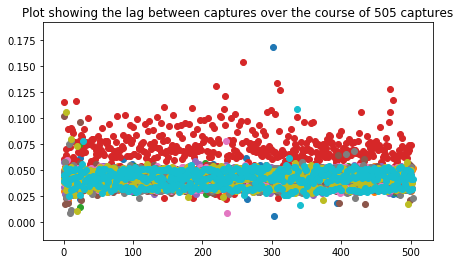

In [31]:
#Func star runner
#runfunc simply allows for a function to be skipped if run with others in a loop, all functions have it as first arg
#The functions below have been ordered chronologically in terms of dependency 
runscript=1
errorstat=0
count=0
failedfolders=[]
if runscript==1:
    start = time.time()
    #input args: run the function (0=no,1=yes), levels of subfolder(1 or 2), parent folder dir
    ##############################################################
    startdir=r'D:\Sharpcap\2020-02-17\Capture'
    workfolders=Foldercrawl(1,2,startdir)
    timcents=dict()
    for targdir in workfolders: 
        count=count+1
        print(count)
        print(targdir)
        calloc=targdir+str('\calibrated')
        os.chdir(calloc)
        
        ##############################################################
        nsig=3
        runfunc=0
        LDProcessor(runfunc,[targdir],nsig)
        # os.chdir(calloc) #necesary
        
        ##############################################################
        runfunc=1
        duration,timestamp,exptime=Timingscript(runfunc)
        
        ##############################################################
        apikey='pbockmtauevbedwc'
        runfunc=1
        lonn=145.0477
        latt=-37.8303
        height=44
        if 'prevconcap' not in locals():
            prevconcap=dict()
            print('prevconcap defined')
        #By the convention that Hawthorn East, Victoria, Aus has a negative Lat and positive Long
        #https://www.distancesto.com/coordinates/au/hawthorn-east-vic-3123-latitude-longitude/history/163865.html    
        date,RAval,DECval,arcang,angspeed,airmass,prevconcap=PlatesolveNova(runfunc,targdir,calloc,
        apikey,duration,lonn,latt,height,prevconcap)
        print(RAval,DECval,airmass)
        
        ##############################################################
        #angspeed=15
        nsig=2.5
        runfunc=1
        starcount,stars,NAXIS1,NAXIS2,tbl,data,segm,errorstat=Starstack(runfunc,'trail.fits',duration,angspeed,nsig,0)
        if errorstat==1:
            print(targdir+' terminating')
            print('moving to next')
            #fill in all blank values or mark folder as a dud or mark for later assessment
            failedfolders.append(targdir)
            continue
            
        ############################################################## 
        runfunc=1
        runplot=0
        testma,aval,stackvals=Maskmaker(runfunc,stars,data,tbl,segm,runplot)
        
        ##############################################################
        runfunc=1
        stars,testma,aval=Starfilter(1,stars,testma,aval,stackvals)
        
        ##############################################################
        first=1
        last=len(glob.glob('calibrated*fits'))+1
        bound=2 # Diameter of 5 
        nsig=3.5 #try with 3 for the statistical advantage
        npix=9
        runfunc=1
        starx,stary,timevalcent,nsig,t,timekeep=Centroider(runfunc,first,last,stars,bound,nsig,npix,testma,c0=1,c1=1)
        if starx =={}:
            print('no remaining stars, skipping')
            failedfolders.append(targdir)
            continue
        #saves the star centroids (x/y) and the capture timestamps, can be reaccessed. 
        namedir=str(targdir).replace('\\','')
        name=namedir+' - '+str(nsig)+" starx.p",namedir+' - '+str(nsig)+" stary.p",namedir+' - '+str(nsig)+" timevalcent.p"
        pickle.dump(starx, open(name[0], "wb")) 
        pickle.dump(stary, open(name[1], "wb"))
        pickle.dump(timevalcent, open(name[2], "wb"))
        timcents[targdir]=([])
        timcents[targdir].append(starx)
        timcents[targdir].append(stary)
        timcents[targdir].append(timevalcent)
        imscale=1.98
        Tablemake('calibrated100.fits',timevalcent,airmass,lonn,latt,bound,imscale,NAXIS2,NAXIS1,RAval,DECval,duration)
        
        #############################################################################################
    imscale=1.98 #"/pix
    D=0.05
    lambd=500*(10**-9) 
    #%%capture cap_out
    #Estimator conducts the seeing estimate and saves the resuluting dataframe/s to the last assignment 
    #for a capture folder
    xymeddif,meddcap=Estimator(timcents,imscale,D,lambd)
    end = time.time()
    time_taken = end - start
    print('Time: ',time_taken)
else:
    print('Function skipped')
print(failedfolders)   
#passlist = [fold for fold in workfolders if fold not in failedfolders]
# #targdir=r'D:\Sharpcap\2020-02-17\Capture\34g-10-1600-1200-STOMP\1'
os.chdir(startdir)
pickle.dump(timcents,open(str(nsig)+' - '+'X-Y-Time.p', "wb")) 
#saves the output of the cell as a backup
#var = cap_out.stdout
#Uncomment below if it should finish with more appropriate pizzazz
#webbrowser.open('https://www.youtube.com/watch?v=9bK9h12Qdvs')

# Timcents (Centroid, time and seeing estimate retreival)

7


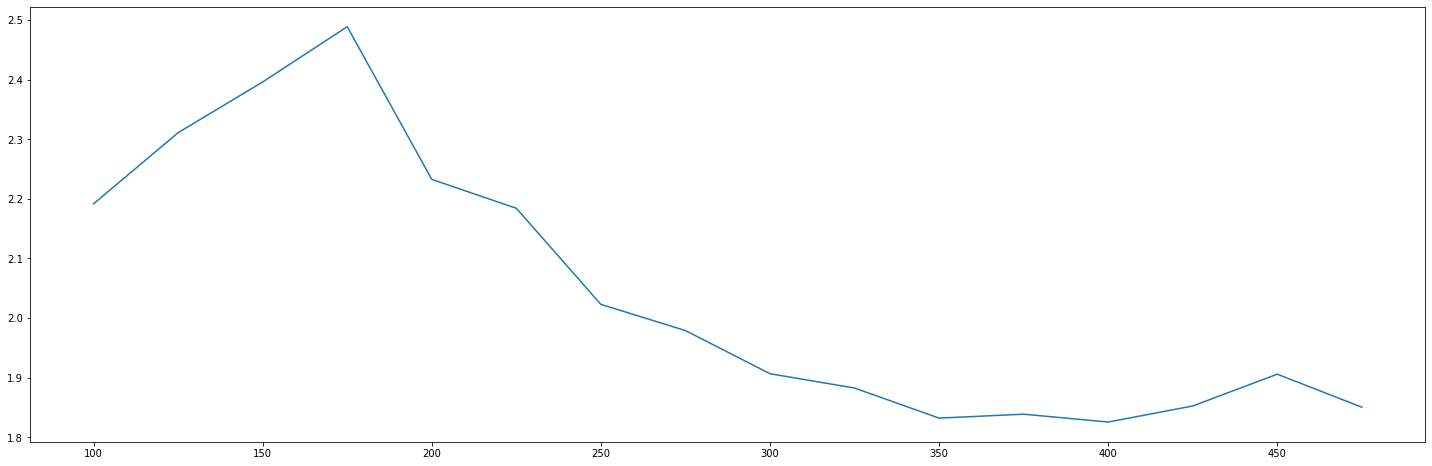

In [1618]:
#THIS ALLOWS FOR INSPECTION OF CHANGE IN SEEING EST OVER CAPTURE NUMBER
nsig=3
medover=[]
startdir=r'D:\Sharpcap\2020-02-17\Capture'
os.chdir(startdir)
timcents = pickle.load(open(str(nsig)+' - '+'X-Y-Time.p', "rb"))
tkeyn=list(timcents.keys())
#
print(len(tkeyn))

for i in (np.arange(100,500,25)):
        #print(i)
        startdir=r'D:\Sharpcap\2020-02-17\Capture'
        os.chdir(startdir)
        nsig=3
        timcents = pickle.load(open(str(nsig)+' - '+'X-Y-Time.p', "rb"))
        centstim=timcents.copy()
        start=0
        finish=i
        for k in centstim.keys():
            #print(k)
            for st in centstim[k][0].keys():
                #print(st)
                for q in range(0,2):
                    centstim[k][0][st][q][0:(len(centstim[k][0][st][q]))]=centstim[k][0][st][q][start:finish]
                    centstim[k][1][st][q][0:(len(centstim[k][1][st][q]))]=centstim[k][1][st][q][start:finish]
                    centstim[k][2][st][0:(len(centstim[k][2][st]))]=centstim[k][2][st][start:finish]
                   # print(len(centstim[k][2][st]))
                #print(len(starx[st][1]))
                #print(len(stary[st][1]))
        imscale=1.98 #"/pix
        D=0.05
        lambd=500*(10**-9) 
        disp=0
        sdval=1.5
        xymeddif,meddcap,resval,linval=Estimator(centstim,imscale,D,lambd,sdval,disp,)
        medover.append(meddcap[1])
        #print(meddcap[5])
plt.plot(np.arange(100,500,25),medover)        

In [1619]:
linval

{'D:\\Sharpcap\\2020-02-10\\Capture\\34g-10ms\\34g-10ms': ([poly1d([-4.47414279e+00,  7.07494257e+09]),
   poly1d([-4.47549306e+00,  7.07707744e+09]),
   poly1d([-4.51247139e+00,  7.13555124e+09]),
   poly1d([-4.49589472e+00,  7.10933928e+09]),
   poly1d([-4.50948783e+00,  7.13083272e+09])],
  [poly1d([ 4.49408168e+00, -7.10647013e+09]),
   poly1d([ 4.50833175e+00, -7.12900342e+09]),
   poly1d([ 4.49889665e+00, -7.11408303e+09]),
   poly1d([ 4.53380229e+00, -7.16927871e+09]),
   poly1d([ 4.45190015e+00, -7.03976688e+09])]),
 'D:\\Sharpcap\\2020-02-10\\Capture\\34g-9ms\\34g-9ms-1': ([poly1d([-4.43741527e+00,  7.01687960e+09]),
   poly1d([-4.43911037e+00,  7.01955914e+09]),
   poly1d([-4.47579242e+00,  7.07756509e+09]),
   poly1d([-4.47076502e+00,  7.06961461e+09]),
   poly1d([-4.46888444e+00,  7.06664072e+09])],
  [poly1d([ 4.45836330e+00, -7.05000197e+09]),
   poly1d([ 4.42667218e+00, -6.99988878e+09]),
   poly1d([ 4.45187272e+00, -7.03973756e+09]),
   poly1d([ 4.43086148e+00, -7.00651

In [1604]:
#HELPS PRODUCE THE RESIDUAL PLOTS
import scipy
from scipy import stats
con=np.array(resval[tkeyn[0]][1][0])
mean = np.mean(con, axis=0)
sd = np.std(con, axis=0)
mad= mad_std(con)
final_list = [x for x in con if (x > mean - 1.2* sd)]
print(type(final_list))
final_list = [x for x in final_list if (x < mean + 1.2 * sd)]
print(str(len(final_list))+' out of '+str(len(con)))
sdfl=np.std(final_list, axis=0)
mdfl=mad_std(final_list)
print(sd,sdfl,mad,mdfl)

<class 'list'>
365 out of 475
0.5111771167679794 0.3306865682876485 0.5269612533402236 0.4182503885377848


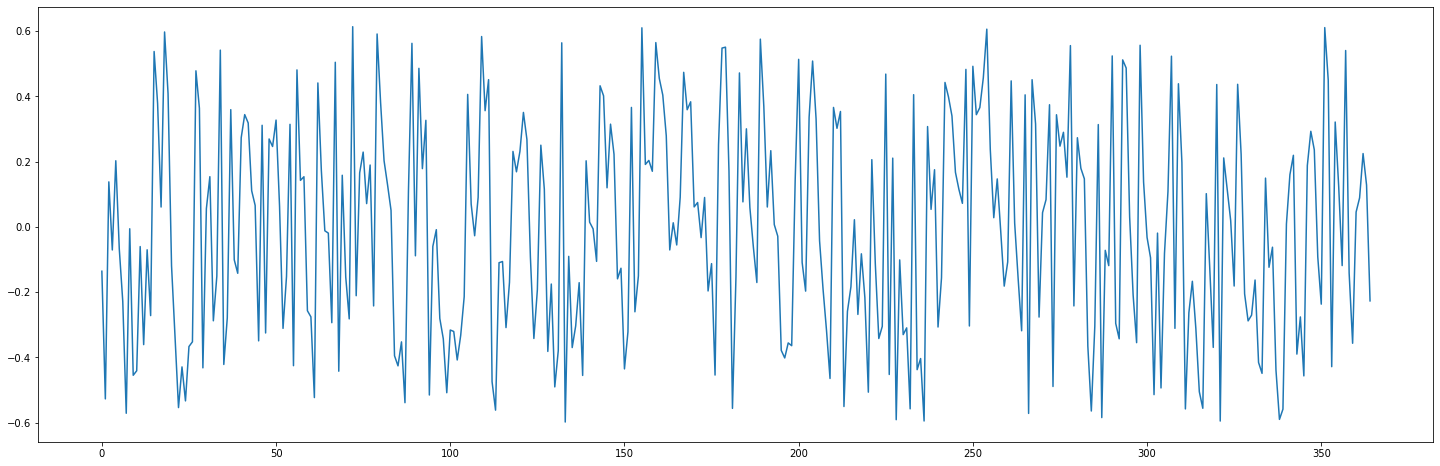

In [1607]:
plt.rcParams["figure.figsize"] = [25,8]
plt.plot(np.arange(0,len(list(final_list)),1),final_list)

Text(0, 0.5, 'Ypixel')

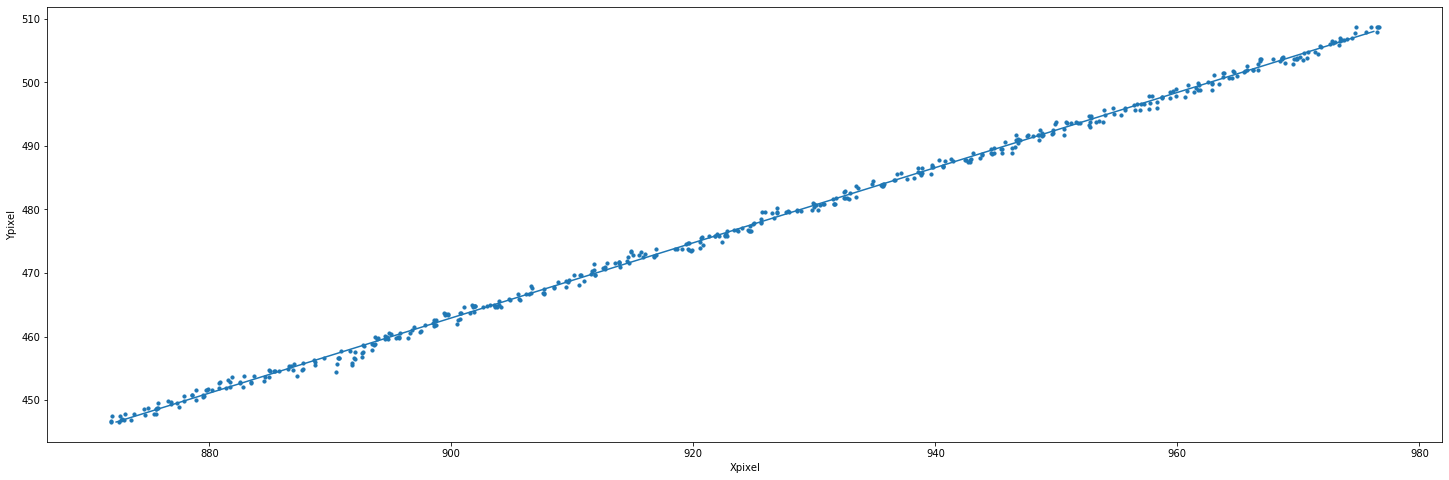

In [1622]:
timx=timcents[tkeyn[dirrr]][2][0]
csx=timcents[tkeyn[dirrr]][0][0][1]
csy=timcents[tkeyn[dirrr]][1][0][1]
linearvalx=linval[tkeyn[dirrr]][0][0](timx)
linearvaly=linval[tkeyn[dirrr]][1][0](timx)
#plt.plot(timx,csy)
plt.scatter(csx,csy,s=10)
plt.plot(linearvalx,linearvaly)
plt.xlabel('Xpixel')
plt.ylabel('Ypixel')

In [22]:
# #graphical inspection 
# t=400
# s=0
# g=str(t+1).zfill(1)
# fitsfile='calibrated'+ g+'.fits'
# hdul= fits.open(fitsfile)
# data = hdul[0].data 
# d1=hdul[0].data
# data3=data[0:1000,500:1500]
# threshold3 = detect_threshold(data3, nsigma=3.5)
# thresh=np.ones((2048,3056))*threshold3[0][0]
# npixel=9
# segm = detect_sources(data, thresh, npixels=npixel,mask=testma[s])
# cat=source_properties(data,segm)
# tbl=cat.to_table()
# head1, sep, tail = str(tbl[0][1]).partition(' ') 
# head2, sep, tail = str(tbl[0][2]).partition(' ') 
# starxx=((float(head1)))
# staryy=((float(head2)))
# bound=5
# lf=round(starxx-bound)
# ri=round(starxx+bound)
# dw=int(round(staryy-bound))
# upup=int(round(staryy+bound))
# data4=data[dw:upup,lf:ri]
# plt.imshow(data, cmap='bone')
# data4=data[dw:upup,lf:ri]
# plt.axis([lf,ri, dw, upup])
# plt.colorbar()
# plt.scatter(centroid_2dg(data4)[0]+lf, centroid_2dg(data4)[1]+dw, c='red',s=100,marker='+')
# plt.scatter(centroid_2dg(data4)[0]+lf, centroid_2dg(data4)[1]+dw, c='red',s=100,marker='+')
# plt.scatter(centroid_1dg(data4)[0]+lf, centroid_1dg(data4)[1]+dw, c='blue',s=100, marker='+')
# plt.scatter(centroid_com(data4)[0]+lf, centroid_com(data4)[1]+dw, c='green',s=100, marker='+')
# plt.scatter(starxx,staryy,c='yellow',s=100, marker='+')
# plt.rcParams["figure.figsize"] = [5,5]
# tbl

D:\Sharpcap\2020-02-17\Capture\34g-7-1600\1
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\1
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\3
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\3
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\4
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\4
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\4
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\4
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\2
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\2
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\3
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\3
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\1
D:\Sharpcap\2020-02-17\Capture\34g-9-1600\1
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\2
D:\Sharpcap\2020-02-17\Capture\34g-7-1600\2


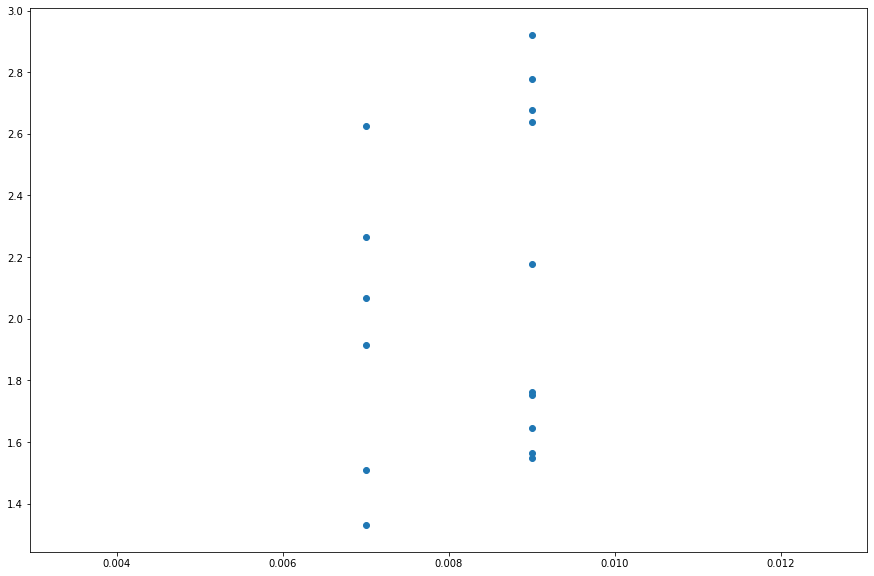

In [1561]:
nsig=3
#medover=[]
startdir=r'D:\Sharpcap\2020-02-17\Capture'
os.chdir(startdir)
timcents = pickle.load(open(str(nsig)+' - '+'X-Y-Time.p', "rb"))
imscale=1.98 #"/pix
D=0.05
lambd=500*(10**-9) 
disp=0
sdval=1
xymeddif,meddcap,resval=Estimator(timcents,imscale,D,lambd,sdval,disp)
medrecov=[]
xrecov=[]
yrecov=[]
exptime=[]
j=timcents
#Retriving all the FWHM estimates from 
for k in j.keys():
    for u in range(0,len(timcents[k][3:])):
        print(k)
        mm=j[k][3+u].loc["Median","COM"]
        mx=j[k][3+u].loc["FWHMx","COM"]
        my=j[k][3+u].loc["FWHMy","COM"]
        medrecov.append(mm)
        #print(mm)
        #print(medrecov)
        xrecov.append(mx)
        yrecov.append(my)
        os.chdir(k+str('\calibrated'))
        fitsfile='calibrated100.fits'
        hdul=fits.open(fitsfile)
        data = hdul[0].data
        h1=hdul[0].header
        #gain.append(hdul[0].header['GAIN'])
        #offset.append(h1['BLKLEVEL'])
        exptime.append(h1['EXPTIME'])
#print(medrecov)
plt.scatter(exptime,medrecov)

In [20]:
#Median of the median FWHM (x and y from segm and com) and the median difference across all captures. 
#print(np.median(meddcap),np.median(xymeddif))

In [96]:
# i=0
# trunckey=list(timcents.keys())
# fname=np.ones(len(medrecov))
# for b in range(0,len(medrecov)):
#     for u in range(0,len(timcents[k][3:])):
#         fname[b]=trunckey[b][-30:-1]
# #     d = {'Path/prop': trunckey,'Exposure-time': exptime,'MED-FWHM': medrecov}
# #     df1 = pd.DataFrame(data=d)
# #     print(df1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\roryf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-bc5d696226a5>", line 6, in <module>
    fname[b]=trunckey[b][-30:-1]
ValueError: could not convert string to float: '2-10\\Capture\\34g-10ms\\34g-10m'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\roryf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\roryf\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:

ValueError: could not convert string to float: '2-10\\Capture\\34g-10ms\\34g-10m'

In [333]:
# cutoff=5
# rid=[]
# medrecov=np.array(medrecov)
# wanted=medrecov[medrecov>cutoff]
# for i in range(0,len(wanted)):
#     rid.append(list(meddcap).index(wanted[i]))
# rid
# meddcap=list(meddcap)

In [164]:
# exptime=np.delete(exptime,(rid),0)
# meddcap=np.delete(meddcap,(rid),0)
# trunckey=np.delete(trunckey,(rid),0)

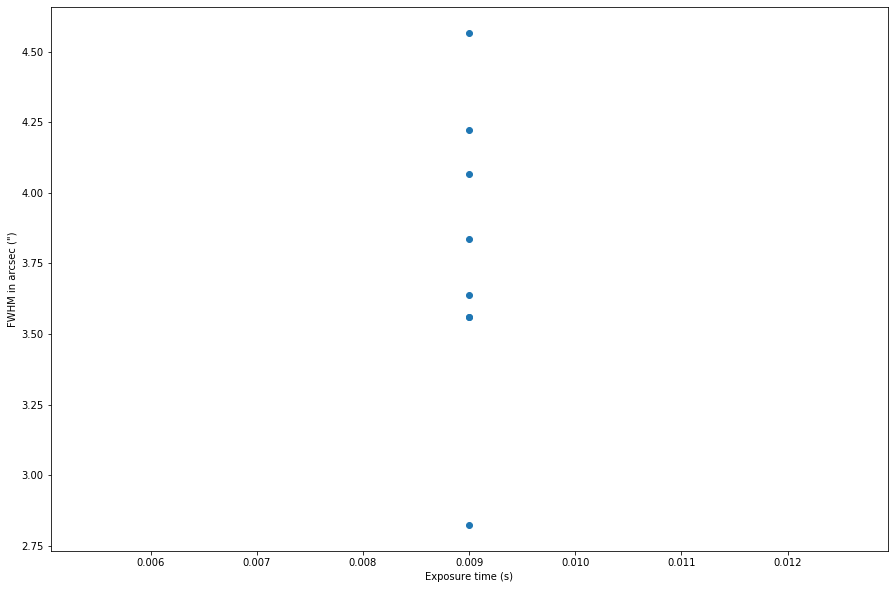

In [1520]:

#meddcap[meddcap<5]
#plt.plot((np.arange(0,len(meddfilt),1)),meddfilt)
plt.rcParams["figure.figsize"] = [15,10]
plt.xlabel('Exposure time (s)')
plt.ylabel('FWHM in arcsec (")')
#plt.scatter(altexptime,altmedrecov)
plt.scatter(exptime,medrecov)
#plt.scatter(exptime,medrecov,color='blue')
#plt.scatter(exptime,xrecov,color='green')
#plt.scatter(exptime,yrecov,color='red')


In [34]:
np.array(residualsx[st][q])

array([ 1.11553457e+00,  7.12749116e-01,  5.03770782e-01,  1.88554150e-02,
       -5.76449465e-02,  9.01345238e-01,  9.33660696e-01,  4.86979814e-01,
        5.33039635e-01,  8.01240747e-01, -1.63613470e-01,  4.96610000e-01,
        2.96895092e-01,  6.08808095e-01,  1.26748358e-01,  1.09208945e-01,
       -7.47785800e-02,  2.31507464e-01,  3.45694904e-02, -2.50282974e-01,
        1.95678786e-01,  6.08723860e-01,  3.20752820e-01, -1.18432616e-01,
        5.34696995e-01,  9.44701308e-02, -1.73327764e-01,  3.48563917e-01,
       -6.51585362e-01, -7.82720024e-01, -7.29508762e-01, -8.08084879e-01,
       -4.09379787e-01, -9.74557418e-01, -8.81333929e-01, -4.61739558e-01,
       -3.74193839e-01, -3.44621388e-02,  5.04424130e-01, -4.45656258e-01,
       -2.61776053e-02, -2.61776164e-01, -5.82525136e-02, -2.20663470e-01,
        4.26458728e-01,  3.47044938e-01, -1.06730297e-01,  1.52361188e-01,
       -9.94534509e-02, -3.80480033e-01, -5.38492135e-01, -2.90108587e-01,
       -4.63545423e-01, -

D:\Sharpcap\2020-02-23\Capture\smallcaps\34g-9ms-1200-1600-0\6
0


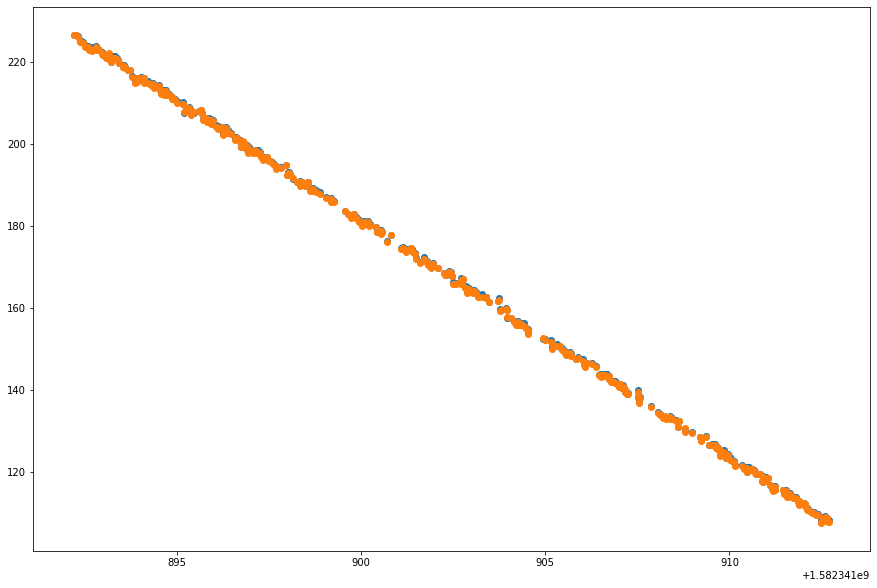

In [44]:
f=list(timcents.keys())[0]
w=list(timcents[f][0].keys())[0]
print(f)
print(w)
# for i in range(0,len(stars)):
plt.subplots(1,1)
plt.scatter(timcents[f][2][w],timcents[f][0][w][0])
plt.scatter(timcents[f][2][w],timcents[f][0][w][1])

D:\Sharpcap\2020-02-23\Capture\smallcaps\34g-9ms-1280-1024-15\11
0


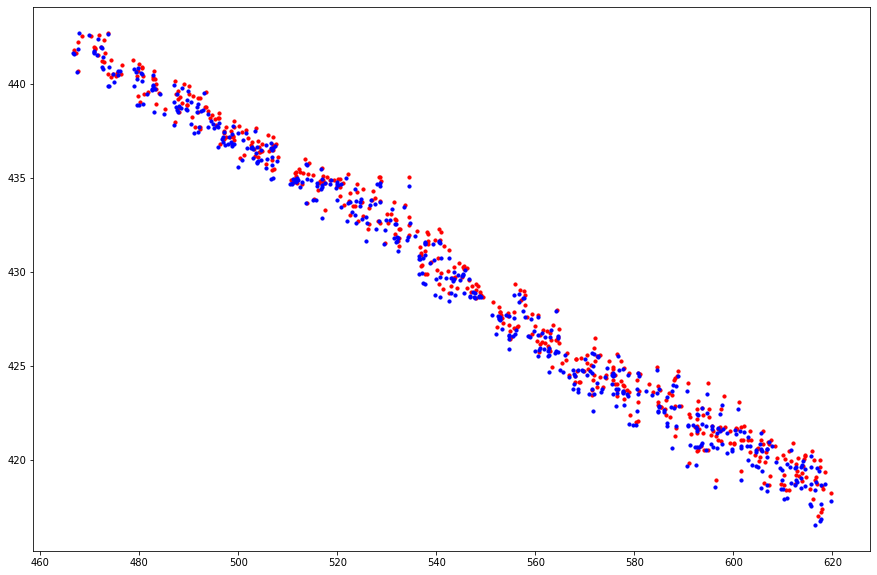

In [45]:
f=list(timcents.keys())[-3]
w=list(timcents[f][0].keys())[0]
print(f)
print(w)
# for i in range(0,len(stars)):
plt.subplots(1,1)
plt.scatter(timcents[f][1][w][0],timcents[f][0][w][0], c='red',s=10,)#SD
plt.scatter(timcents[f][1][w][1],timcents[f][0][w][1],c='blue',s=10,)#COM

# residual by best fit from xy

In [130]:
f=list(timcents.keys())[0]
f

'D:\\Sharpcap\\2020-02-23\\Capture\\smallcaps\\34g-9ms-1200-1600-0\\7'

In [101]:
plt.plot(px(timevalcent[0],py(timevalcent[st])

SyntaxError: unexpected EOF while parsing (<ipython-input-101-588d8d5663da>, line 1)

In [ ]:
# corrseeing=(airmass**-0.6)*FWHM
# corrseeing

# Reget the final date

In [411]:
# #Use the middle date of the capture series
# #fitsfile='calibrated1'+str(np.int(len(timekeep)/2))+'.fits'
# fitsfile='calibrated1.fits'
# gain=[]
# offset=[]
# date=[]
# exptime=[]
# #accesses the pixel info from the fits header
# hdul= fits.open(fitsfile)
# data = hdul[0].data
# h1=hdul[0].header
# d1=hdul[0].data
# date=(h1['DATE-OBS']) 
# gain.append(h1['GAIN'])
# offset.append(h1['BLKLEVEL'])
# exptime.append(h1['EXPTIME'])
# airmass=1
# bound=2
# imscale=1.98

In [166]:
df1.append(d , ignore_index=True)

,Date captured (UTC),Star number,Est Airmass,Longitude,Latitude,Gain,Exposure time,Offset,bound,pixscale,Npixx,Npixy,# of frames,Centre RA,Centre DEC
0,2020-02-16T13:51:22.6017178,1,[1.0],145.046,-37.824,34,0.009,420,2,1.98,2048,3056,1,132.491,-36.1114
1,2020-02-16T13:51:22.6017178,1,[[1.0]],145.046,-37.824,[34],[0.009],[420],2,1.98,2048,3056,1,[132.491126449],[-36.1114171075]


In [412]:
# if 'count' not in locals():
#     count=0
# nstar=np.arange(1, len(stars)+1, 1)
#for i in len(starx[0][0 maybe])
#for i in range(0,len(nstar)):

d = {'Date captured (UTC)': date,'Star number': len(timevalcent), 'Est Airmass': airmass,'Longitude': lonn,'Latitude': latt,
    'Gain': gain,'Exposure time': exptime,'Offset': offset,'bound':bound, 'pixscale': imscale,'Npixx':NAXIS2,'Npixy':NAXIS1
    ,'# of frames':len(timevalcent),'Centre RA': RAval,'Centre DEC': DECval,}
df1 = pd.DataFrame(data=d)
df1.to_csv('context'+str(count) +'.CSV')

NameError: name 'lonn' is not defined

In [169]:
len(cx)

387

In [170]:
# if 'count' not in locals():
#     count=0
#df1.append(g , ignore_index=True)    
#for i in range(0,len(starx)):
d = {'Date/Time captured': date,'Star number': starx.keys()[i], 'Airmass': airmass,'Angle':anglemed,
    'Gain': gain,'Exposure time': exptime,'Offset': offset,'bound':bound, 'pixscale': imscale,
     'Calculated r0(cm)': r0,'Calculated FWHMx 2dfit ('')': (FWHMx)[i],'Calculated FWHMy 2dfit ('')': (FWHMy)[i],'Calculated FWHM med ('')': FWHMav[i],'Scale': imscale,'Npixx':NAXIS2,'Npixy':NAXIS1
    ,'# of frames':len(cx)}
df2 = pd.DataFrame(data=d)
count=count+1
#df2.to_csv('FWHM'+str(count) +'.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\roryf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-170-d4d90339ab87>", line 3, in <module>
    df1.append(g , ignore_index=True)
  File "C:\Users\roryf\Anaconda3\lib\site-packages\pandas\core\frame.py", line 6692, in append
    sort=sort)
  File "C:\Users\roryf\Anaconda3\lib\site-packages\pandas\core\reshape\concat.py", line 228, in concat
    copy=copy, sort=sort)
  File "C:\Users\roryf\Anaconda3\lib\site-packages\pandas\core\reshape\concat.py", line 289, in __init__
    raise TypeError(msg)
TypeError: cannot concatenate object of type "<class 'int'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\roryf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 203

TypeError: cannot concatenate object of type "<class 'int'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [167]:
df1

,Date captured (UTC),Star number,Est Airmass,Longitude,Latitude,Gain,Exposure time,Offset,bound,pixscale,Npixx,Npixy,# of frames,Centre RA,Centre DEC
0,2020-02-16T13:51:22.6017178,1,[1.0],145.046,-37.824,34,0.009,420,2,1.98,2048,3056,1,132.491126,-36.111417


# Plots!

In [ ]:
plt.rcParams["figure.figsize"] = [15,10]
plt.scatter(cx,cy)
plt.scatter(starx[1][1],px(timevalcent[1]))
plt.rcParams["figure.figsize"] = [15,10]

In [ ]:
plt.rcParams["figure.figsize"] = [15,10]
plt.scatter(timevalcent[1],residualsy)
plt.scatter(timevalcent[1],residualsx)
# plt.plot(timevalcent[1],residuals,'g')


In [ ]:
#x,y-axis residuals
#centroid values
yx=px(timevalcent[1])
yy=py(timevalcent[1])
plt.subplot(3,1,1)
plt.plot(timevalcent[1],cx,'.r')
#plt.plot(n,cx-residualsx,'.')  
plt.vlines(timevalcent[1],cx,cx+residualsx)
#fitted line
plt.plot(timevalcent[1],yx)
plt.title('Diurnal motion of sequential star x-axis centroids with an RMSE of '+str(sigradx))
plt.ylabel('X-axis centroid position (pix)')
#plt.xlabel('Nth capture x-centroid')
#y-axis residuals
#centroid values
plt.subplot(3,1,2)
plt.plot(timevalcent[1],cy,'.r')
#plt.plot(n,cx-residualsx,'.')  
plt.vlines(timevalcent[1],cy,cy+residualsy)
#fitted line
plt.plot(timevalcent[1],yy)
plt.ylabel('Y-axis centroid position (pix)')
#plt.xlabel('Nth capture y-centroid')
plt.title('Diurnal motion of sequential star y-axis centroids with an RMSE of '+str(sigrady))
plt.rcParams["figure.figsize"] = [35,60]

In [74]:
meanresx=[]
grad=10
spacedlist=np.arange(0,len([starx][0][0]),grad)
for i in spacedlist:
     meanresx.append(np.mean(residualsx[i-4:i+4]))
meanresx        
#SUGGESTION, DEFINE ARRAY THAT HAS INTERVAL EVERY GRAD AND THEN LOOP THROUGH

-0.2385706119385418
-0.23685665272511186
-0.1880196485856686
-0.14909129390301815
-0.09220455160334495
-0.10444795122681398
-0.11826215181549742
-0.10621123185608213
-0.10272493656673305
-0.1686862742686003
-0.25809473205135874
-0.24401277620207792
-0.2198759075085263
-0.2028524228359288
-0.10907677848176718
-0.1412449096108162
-0.17595159589187687
-0.18121139475475728
-0.1551154814549136
4.419258782490942e-05
0.016605521664860134
0.0432683007002538
0.0028309843338320206
-0.01301920424407399
-0.08897730061162293
-0.08616520149753341
-0.09858974683435236
-0.15335293541276088
-0.18039229099628074
-0.11153241891574908
-0.06811439954769867
-0.055579388568855845
-0.05629313316507023
-0.03627165422138887
-0.10242755371805287
-0.04289975892936582
-0.10473062193231045
-0.08575979080279694
-0.044304787169323845
-0.038079547503048164
0.059933060157686666
0.042710636529693605
0.0920848781949303
0.12813062569795192
0.252768200305627
0.2833799464635831
0.28923545852677535
0.32195384599202725
0.3905

480

In [414]:
np.max(residualsx),np.max(residualsy)

(1.6993720574695317, 4.881131392350881)

In [ ]:
#pOSSIBLE CIRCLE FIT
#xc,yc,r2,_ = cf.least_squares_circle((list(zip(cx,cy))))
#xc

In [ ]:
# #POSSIBLE CIRCLE PLOT
# import numpy as np
# import matplotlib.pyplot as plt

# theta = np.linspace(0, 2*np.pi, 100)

# r = np.sqrt(r2**2)

# x1 = r*np.cos(theta)
# x2 = r*np.sin(theta)

# fig, ax = plt.subplots(1)

# ax.plot(x1+xc, x2+yc)
# ax.set_aspect(1)
# plt.plot(x, b + m * x, '-')
# plt.xlim(500,1000)
# plt.ylim(800,1400)
# plt.scatter(cx,cy)
# plt.grid(linestyle='--')

# plt.title('How to plot a circle with matplotlib ?', fontsize=8)

# #plt.savefig("plot_circle_matplotlib_01.png", bbox_inches='tight')
# plt.rcParams["figure.figsize"] = [10,15]
# plt.show()

In [ ]:
#Chord calc
theta=0.49
radi=1
arcl=(theta/360)*2*radi*(np.pi)
chrdl=2*radi*np.sin(np.deg2rad(theta/2))
#chrdl/arcl

In [163]:
timcents.keys

{'D:\\Sharpcap\\2020-02-23\\Capture\\smallcaps\\34g-9ms-1200-1600-0\\7': [{1: ([247.11613526570048,
     247.50626652868806,
     246.68911335578002,
     247.5236451823524,
     246.52650215779573,
     247.08064121390112,
     246.44293645897594,
     246.00563127397373,
     244.40049884197398,
     245.1377497371188,
     244.94379763799313,
     243.85754761529986,
     243.71831651954602,
     242.3270136307311,
     243.88565132223312,
     244.2798692117356,
     243.528636884307,
     244.50017273146017,
     243.1984392419175,
     243.2101952827796,
     243.25265192822445,
     243.1920122887865,
     243.31110917183,
     241.72469405179774,
     242.13725490196077,
     243.27006260671598,
     242.02157928388746,
     240.9572783263271,
     240.74736011052994,
     241.33528680518558,
     240.45918705656123,
     241.27014546294157,
     239.85443357207708,
     239.96656388514165,
     240.35046857772878,
     239.43912622083053,
     238.66397018723868,
     239.2222

In [ ]:
# st1=0
# st2=1
# xsep=[]
# ysep=[]
timcents[f][1][w][0],timcents[f][0][w][0],
#     xsub=(starx[s][0][b]-starcent[st2][0][b])
#     ysub=starcent[st1][1][b]-starcent[st2][1][b]
#     xsep.append(xsub)
#     ysep.append(ysub)
# plt.scatter(xsep,ysep)